# Computer Vision - Assignment 1 - Image Filtering

#### 10 points   |   Deadline: 24th of March 2024, 23:59   |   Submission site: https://pradoposgrado2324.ugr.es/course/view.php?id=6425

### Student's name: <mark>Seyedeh Kimia Arfaie Oghani</mark>





---



## Submission rules

For this submission (and the same applies to all other course assignments), code, results, discussion, presentation and analysis of the work carried out must be introduced, all integrated into this same Google Colab Notebook. Please remember that **code and results without an explanatory report are not enough (and, as a consequence, the associated mark would be 0)**. In other words, it is essential that the student demonstrates that he/she understands what is doing, and that he/she masters the fundamentals to successfully carry out the assignment and interpret the results obtained.

The main goal of this assignment is to become familiar with the implementation and use of convolutional filters, as well as the calculation of the derivatives of an image and its possible applications.

The cell layout/structure of this Google Colab Notebook template must be respected.

Only the source code will be delivered (`.ipynb` file incorporating code, results, and explanation of the work performed and the results obtained). The images used will not be submitted (because we all employ the same images, and these are shared in https://pradoposgrado2324.ugr.es/mod/url/view.php?id=66982).

The path for reading images, or any other input file, must always be “/content/drive/My Drive/images/file_name”

The code must be well-commented, and presented with the results obtained in each section along with the corresponding comments and discussion. Again, remember that submitting code without an explanatory report does not score.



---



## Support functions and connection to Google Drive


In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [ ]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [ ]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Apple',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Apples',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Exercise 1: mask discretization and Gaussian filtering** (4 points).

In this exercise we will learn to discretize convolution masks and apply them to images using OpenCV functions. We also seek to do it in an efficient way, and that is why, in all this assignment, the use of 1D (separable) convolutions is required.

The PDF document about Gaussian discretization, available in PRADO (https://pradoposgrado2324.ugr.es/pluginfile.php/171241/mod_folder/content/0/SupplementaryMaterials/Gaussian_discretization.pdf), can be helpful in the implementation of this first exercise.




## A) (1.5 points)

Compute the 1D discrete masks of the Gaussian function, and both its first and second derivatives (normalized). Consider that the input to such a 1D mask creation function can be both a possible sigma or a possible mask size. Use the following sigma values ($\{1, 2.5, 5\}$) and the following mask size values ($\{5, 9, 15\}$), and display the profile (that is, the silhouette of the masks as 1D functions) to verify that the created masks are correct.

In [ ]:
def GaussFunc(x,sigma):
    return np.exp(-(x**2/(2*sigma**2)))

def GaussDeriv1Func(x,sigma):
    return -(x/sigma**2)*GaussFunc(x, sigma) # Using the GaussFunc(x, sigma), since the formula repeats

def GaussDeriv2Func(x,sigma):
    return ((x**2-sigma**2)/(sigma**4))*GaussFunc(x, sigma)

def gaussianMask1D(sigma=None, sizeMask=None, order=0):

    #Condition to see if either sigma, or sizeMask are provided
    if sigma is not None: # Sigma is provided
        sizeMask = int(2*(3*sigma)+1)
    elif sizeMask is not None: # Sizemask is provided
        sigma = (sizeMask-1)/6

    x = np.arange(-3*sigma, 3*sigma+1) # We know that almost all the values are within 3 standard deviations of the mean, so it is the suitable range for x.

    #Normalizing, which is different for orders of 0, 1 and 2

    if order == 0: #Gaussian Function
        mask = GaussFunc(x, sigma)
        mask /= np.sum(mask) #Normalizing the function for the order = 0, setting the sum of the elements in the mask to one.
    elif order == 1: # First Derivative
        mask = sigma*GaussDeriv1Func(x, sigma) #Multiplying by sigma is done to keep the responce scale-variant
    elif order == 2: # Second Derivative
        mask = (sigma**2)*GaussDeriv2Func(x, sigma) #multiplying by sigma**2 for the same reason as above
    return mask

**1.A) Discussion**

First, the functions for Guassian, first derivative and second derivative of Gaussian were written based on their respective formula. In these functions we can see that we have the sigma parameter, which is the "spread" of the distributions, which later we will see that for instance controls the amount of smoothing when using a Gaussian smoothing kernel.
Then, the gaussianMask1D function was written to compute the 1D discrete masks of the functions. The function can get both the sigma or the size mask as inputs (the if condition tells the function which is the case), calculate the other based on the input, and then calculate the mask. In discretization of the Gaussian, we have to determine the range of x values; We know that almost all values are within 3 standard deviations of the mean, so it makes sense to use from -3sigma to sigma.

The important note to take in mind here is the normalizing.

Normalizing in order of 0 (Gaussian Mask) is done to prevent the image from saturating to white and the pixel values going beyond the value of 1, therefore we set the sum of the elements in the mask to one. For the orders of 2 and 3 (First and Second Derivatives), we have scale normalization; this is done due to the fact that as sigma increases, the response of the derivative of a Gaussian decreases; so we multiply the first derivative by sigma and the second derivative by the sigma**2, to keep the responses the same (scale-invariant).

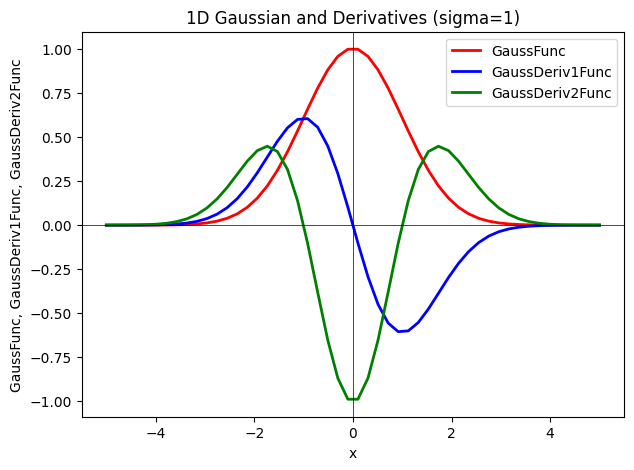

In [ ]:
# With the following figure we check that the implemented Gaussian functions are correct
plt.figure(figsize=(7, 5))  # Set a fixed figure size (width, height)
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend()

WE FIRST SET THE MASK SIZE


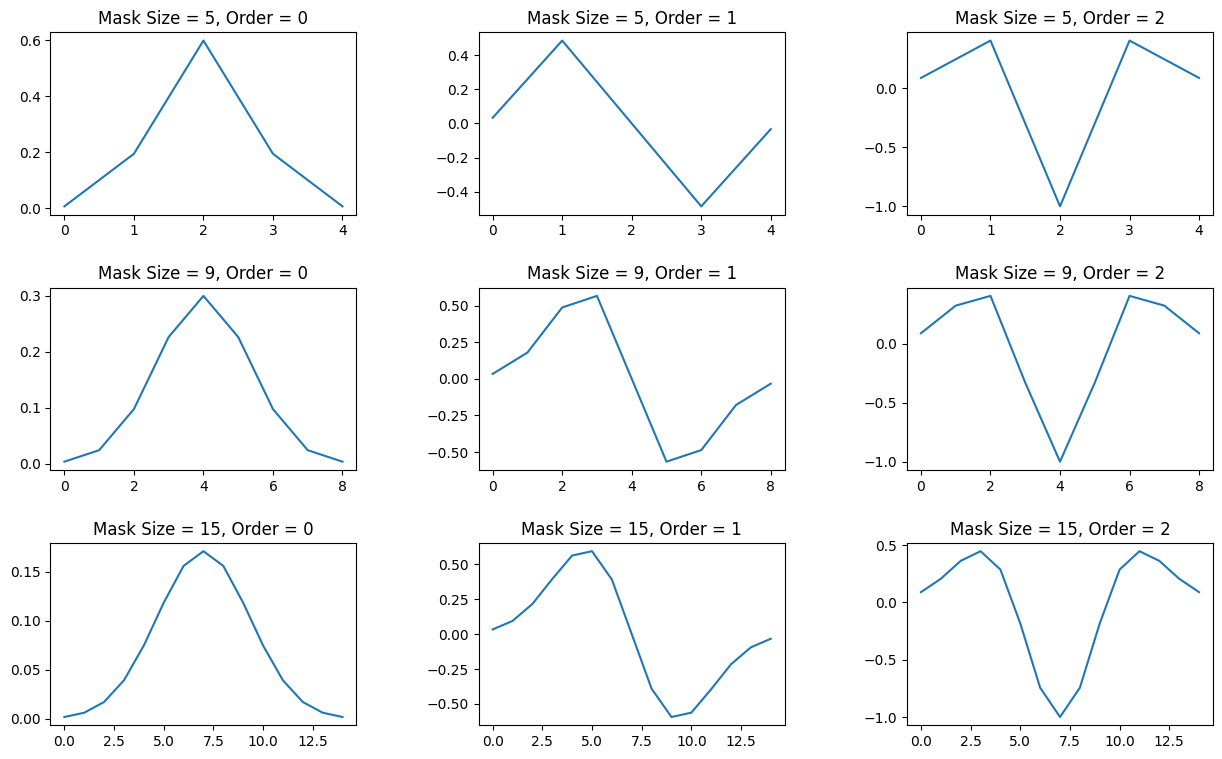

WE NOW SET SIGMA


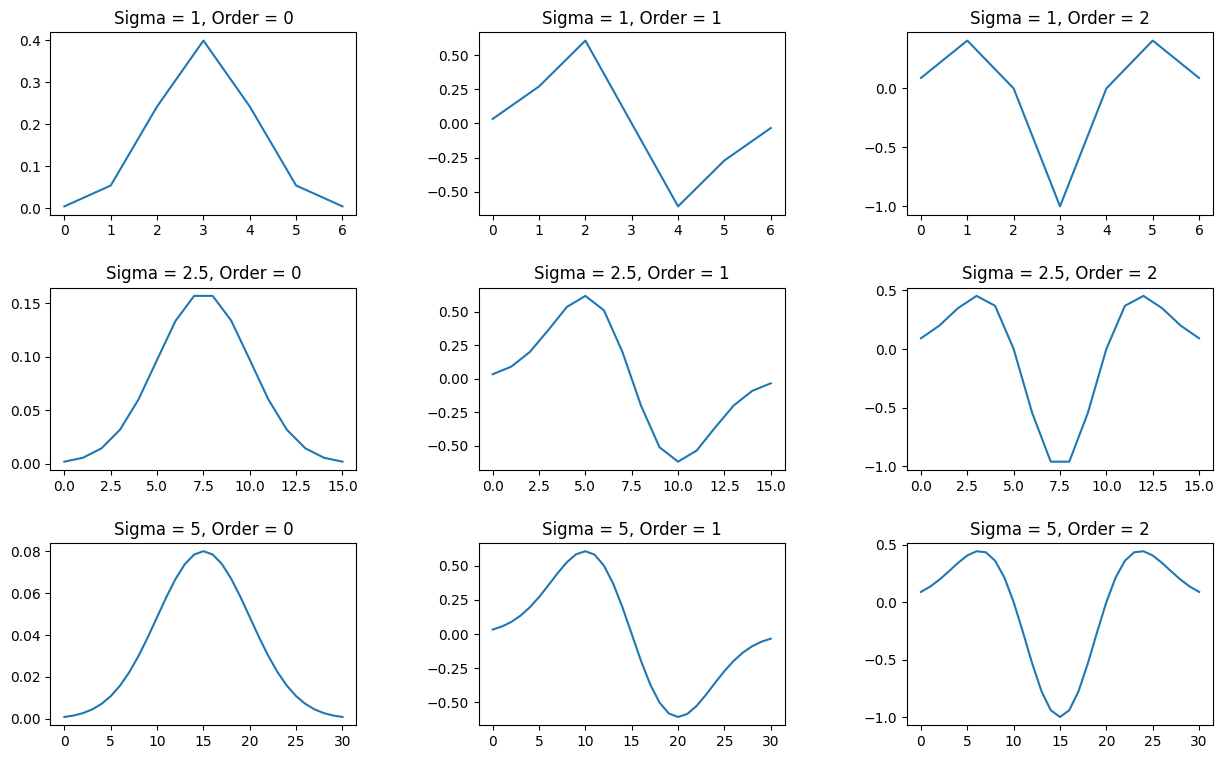

In [ ]:
sigma_values = [1, 2.5, 5]
size_masks = [5,9,15]

plt.rcParams["figure.figsize"] = (15,3) # To adjust height and width (axis)

print('WE FIRST SET THE MASK SIZE')

fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # Adjust the figure size
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

for i, sizeMask in enumerate(size_masks): #Looping through the size masks that are given
    for j, order in enumerate([0,1,2]):
        mask = gaussianMask1D(sizeMask = sizeMask, order=order) #Getting the mask for the current size mask
        axs[i, j].plot(mask)
        axs[i, j].set_title(f'Mask Size = {sizeMask}, Order = {order}')
plt.show()

print('WE NOW SET SIGMA')

fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # Create a new figure for sigma values
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing again for the new set

for i, sigma in enumerate(sigma_values):
    for j, order in enumerate([0,1,2]):
        mask = gaussianMask1D(sigma = sigma, order=order)
        axs[i, j].plot(mask)
        axs[i, j].set_title(f'Sigma = {sigma}, Order = {order}')
plt.show()

**1.A) Discussion**
1. Setting the mask size: we see that as the mask size increases, the curves become smoother and more continous rather than being pointy. We can say that a smaller mask is a more discrete approximation of the Gaussian function, and increasing the mask size provides a closer approximation.
2. Setting the sigma: we can see the same happening with these plots.

## B) (1.5 points)

Read a grayscale image and filter it showing the result of the convolution with a Gaussian, with the first derivative of the Gaussian (both in $X$ and $Y$), and with the second derivative of the Gaussian (both in $X$ and $Y$). Use the following sigmas: $\{0.75,2,5,10,15\}$. Display all images within the same canvas, as shown below. In this section, the OpenCV function `sepFilter2D()` must be used with the masks calculated in the previous exercise.




In [ ]:
def my2DConv(im, sigma, orders):
  ddepth=cv2.CV_64F
  maskG=gaussianMask1D(sigma, order=0) #Getting the masks from the previous functions
  maskDG=gaussianMask1D(sigma, order=1)
  mask2DG= gaussianMask1D(sigma, order=2)

# Ensure the masks are in the correct format (1D numpy arrays), Masks should be 1D arrays to be used by sepFilter2D
# This was done due to an error that was happening regarding the format of the masks
  maskG = np.array(maskG, dtype=np.float64).flatten()
  maskDG = np.array(maskDG, dtype=np.float64).flatten()
  mask2DG = np.array(mask2DG, dtype=np.float64).flatten()

  if orders == [0, 0]: # Gaussian smoothing
    return cv2.sepFilter2D(im, ddepth, maskG, maskG) # Function needs two masks for X direction and Y direction, which for an order of 0,0 , both are gaussian functions
  elif orders == [1, 0]: # First derivative in X direction, and in Y we have gaussian smoothing
    return cv2.sepFilter2D(im, ddepth, maskDG, maskG)
  elif orders == [0, 1]: # First derivative in Y, and in X we have gaussian smoothing
    return cv2.sepFilter2D(im, ddepth, maskG, maskDG)
  elif orders == [2, 0]: # Second derivative in X, and in Y we have gaussian smoothing
    return cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
  elif orders == [0, 2]: # Second derivative in Y, and in X we have gaussian smoothing
    return cv2.sepFilter2D(im, ddepth, maskG, mask2DG)
  else:
    print('Error in order of derivative')

# let's check the function
im=cv2.imread(get_image('zebra.jpg'),0)
vim0=[]
orders=[0,0]
for sigma in [0.75,2,5,10,15]:
  vim0.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
displayMI_ES(vim0,'Zero derivative [0,0]',2)

vim1=[]
orders=[0,1]
for sigma in [0.75,2,5,10,15]:
  vim1.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
displayMI_ES(vim1,'First derivative [0,1]',2)

vim2=[]
orders=[1,0]
for sigma in [0.75,2,5,10,15]:
  vim2.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
displayMI_ES(vim2,'First derivative [1,0]',2)

vim3=[]
orders=[0,2]
for sigma in [0.75,2,5,10,15]:
  vim3.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
displayMI_ES(vim3,'Second derivative [0,2]',2)

vim4=[]
orders=[2,0]
for sigma in [0.75,2,5,10,15]:
  vim4.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
displayMI_ES(vim4,'Second derivative [2,0]',2)


Output hidden; open in https://colab.research.google.com to view.

**1.B) Discussion**
1. Gussian Smoothing: As it can be seen, in the plots, in orders of [0,0] (Meaning Applying Gaussian on both X and Y directions), we only have smoothing of the image with the Guassian kernel. As we know, the sigma in a Guassian function is the spread of the function, meaning with a higher sigma, the guassian function is more spread out, giving a higher smoothing effect.
Going from 0.75 to 15, we can see that the blurring gets higher and higher for the images.

2. First Derivative orders of [0,1]: In this function Guassian smoothing is applied in X direction and First derivative of Gaussian on the Y direction. This is where we say we smooth in one direction and differentiate in another, allowing us to seperate what was once a 2D into two 1D kernels (using seperability feature). With the smallest sigma value, the filter highlights fine **vertical changes** in intensity, which we can see are mostly corresponding to the edges of the zebra stripes. As the sigma value increases, we can see the smoothing effect of the kernel,and also  the fact that now the kernel is less sensitive to small and fine changes and significant changes are more highlighed. Therefore, the strips of the zebra appear thicker and smoother

3. First Derivative orders of [1,0]: In this function Guassian smoothing is applied in Y direction and First derivative of Gaussian on the X direction. The filters highlight **horizontal changes** of intensity in the image, going from the smallest sigma (highlighting fine details) to bigger simga (highlighting more significant changes).

4. Second derivative [0,2]: In this function Guassian smoothing is applied in X direction and Second derivative of Gaussian on the X direction. This filter  highlights the parts in image where the intensity changes abruptly, in this case vertically. We can say that the main advantage of the second derivative of Gaussian is that they allow us to locate the edge more precisely.

5. Second derivative [2,0]: The explanation is the same as the 4th one but in horizontal way.

## C) (1 point)

Use the OpenCV function `sepFilter2D()` and $\sigma=3.0$ to calculate the gradient (4 images: $X$ derivative, $Y$ derivative, magnitude and orientation) and the Laplacian of Gaussian.

In [ ]:
# I will be using the my2DConv function, since we know it is based on sepFilter2D() function.
sigma = 3

# Gradient, 𝑋  derivative

im_gradientx = my2DConv(im,sigma,orders=[1,0])
# Using rangeDisplay01 for better visualization
# Since it is X derivative, order of [1,0] of my2DConv function is used.
displayIm(im_gradientx,'derX')

# Gradient, Y  derivative

im_gradienty =  rangeDisplay01(my2DConv(im,sigma,orders=[0,1]))
# Since it is Y derivative, order of [0,1] of my2DConv function is used.
displayIm(im_gradienty,'derY')

# Magnitude

# For calculating the magnitude we need 𝑋 and Y derivatives, which were again calculaed with my2DConv function
mag = np.sqrt((my2DConv(im,sigma,orders=[1,0]))**2 + (my2DConv(im,sigma,orders=[0,1]))**2)
displayIm(mag,'Magnitude')

# Orientation

# Orientation is the angle that is between the two Gradients of Y and X derivative
# Since it is the arc tangent we want to calculate,  the [0,1] order (Y derivative) is the first argument of the function.
orientation = np.arctan2(my2DConv(im,sigma,orders=[0,1]), my2DConv(im,sigma,orders=[1,0]))
displayIm(orientation,'Orientation')

# Laplacian of Gaussian

#LoG is actually sum of the second derivatives in X and Y direction
im_gradient2Dx =  my2DConv(im,sigma,orders=[2,0])
im_gradient2Dy =  my2DConv(im,sigma,orders=[0,2])
LoG = im_gradient2Dx + im_gradient2Dy
displayIm(LoG,'Laplacian of Gaussian')

Output hidden; open in https://colab.research.google.com to view.

**1.C) Discussion**

**Gradient of an Image:** Overal we can say that gradient of a function points to the direction of the greatest rate of increase of the function. In working with images, the gradient points in the direction of most rapid increase in intensity. The mathematical expression of the gradient can be seen as followed:

∇f=[∂f/∂x , ∂f/∂y],


which ∇f is composed of the partial derivatives of the function (image) with respect to x and y. The ∂f/∂x measures how the intensity changes in the horizontal direction, and ∂f/∂y measures how the intensity changes in the vertical direction.

Note: Since Gradinet of X direction is the first derivative of the image, I used the my2DConv function with orders of [1,0], meaning first order image derivative in X direction. The same logic applies to Gradient of Y.

**Magnitude of Gradient:**
The magnitude of the gradient gives us the edge strength; This value is high in regions of the image where there is a strong intensity change, which we can say typically corresponds to an edge (we may or may not have a significant edge; depends on the image). Magnitude tells us how "strong" that edge is.

∥∇f∥ = sqrt[(∂f/∂x).^2 + (∂f/∂y).^2]

Note: The code written for the magnitude replicates the formula using my2DConv function.

**Gradient Orientation:**
The orientation indicates the direction in which the intensity changes most rapidly in the image and can be calculated by the following formula:

θ = arctang(∂f/∂y, ∂f/∂x)

As it can be seen the formula uses the vertical change and the horizontal change to compute the orientation, which is what I have done in the code to calculate the orientation.

**Laplacian of Gaussian**
LoG is a second derivative filter in which the laplacian and gaussian operations are combined. Dealing with a second derivative filter on an image, an edge occures when the graph of second derivatie crosses zero (zero crossings, sign of the second derivative changes at the location of the edge) and that is how LoG will finds the edges of the image. The laplacian operator is the divergence of the gradient, so we can say it is the sum of the second order derivatives.

∇.^2f = ∂.^2f/∂.^2x + ∂.^2f/∂.^2y

**Image Outputs:**

X Derivative:
The image derivative is applied only in the x direction, and it can be seen clearly in the result that the rapid changes of intensity in X direction are highlighted, specially in the zebra skin.

Y Derivative:
The image derivative is applied only in the y direction. Again, it can be seen clearly in the result that the changes of intensity in Y direction are highlighted.

Magnitude:
The resutls indicate the fact that in magnitude, all the changes in intensity are clear, regardless of the direction. So the white edges are where we had changes of intensity in image and black parts are where we had no change.

Orientation:
We can think of orientation as the angle of an arrow going from the the black parts of the image to the white part of the image, meaning the orientation of the gradients.

Laplacian of Gaussian:
We can see that the edges of the image are clearly extracted, we can see there is less noise compared to the edges in X Gradient, which is one of the advantages of LoG because it is a combination of Gaussian and Laplacoan operations.

# **Exercise 2**:  Gaussian and Laplacian pyramids (3 points)







## A) (1.5 points)

Build a 4-level Gaussian pyramid using $7\times7$ size Gaussian masks. Using the OpenCV `pyrUp()` and `pyrDown()` functions is not allowed.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Apples Pyramid')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

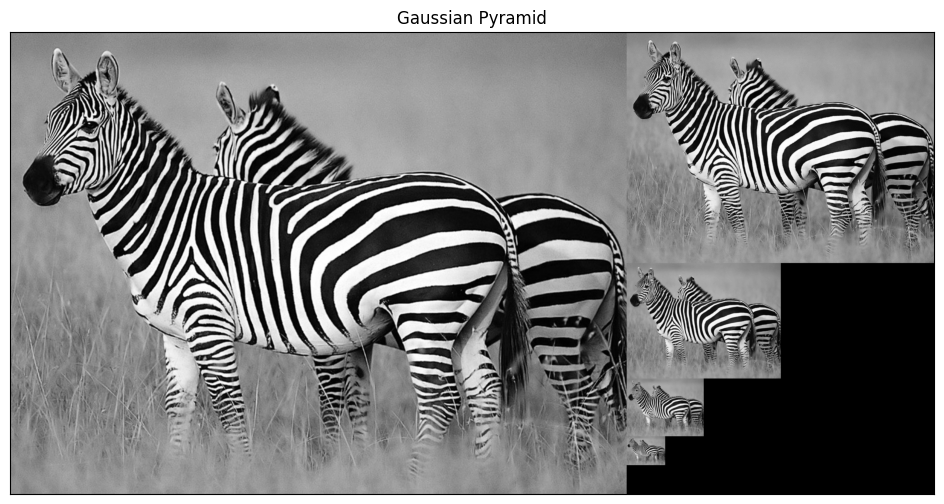

In [ ]:
'''
This function takes the image, mask size and level of gaussian pyramid as input;
It calculates the sigma from mask size;
smooth the image, subsample it and saves it to repreat the operations in the next level.
The function returns a list of images of Gaussian Pyramid contaning also the original image.
'''
def pyramidGauss(im,sizeMask=7, nlevel=4):
  vim=[im] # Creating a list of images for the pyramid, and the first image is the original image.
  #In a Gaussian Pyramid, first we apply Gaussian Smoothing, whcih with the gaussianMask1D, we can achieve it with order of 0
  sigma = (sizeMask-1)/6
  orders = [0,0]

  for _ in range(1, nlevel+1): # Looping through 1,2,3,4 to indicate the levels of pyramid
        # Smooth the image with the Gaussian mask
        im_smoothed = my2DConv(im, sigma, orders) # Applying the Gaussian Smoothing in both dirrections of X and Y
        # Subsample the smoothed image by deleting every other row and column
        downsampled = im_smoothed[0::2, 0::2]
        # Append the downsampled image to the vim list
        vim.append(downsampled)
        im = downsampled #updating the im to downssampled image, so in each new level in the loop, we smooth and downsample the new image
  return vim

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')


**2.A)Discussion**

**Pyramids**
Pyramids are collection of same images in different scales; as we go up in the pyramid, the image is subsampled. Pyramids can be useful in many applications such as image blending, noise removal, image compression and etc.

**Gaussian Pyramids**
In Gaussian Pyramids, first guassian smoothing is applied to the original image, and then subsampling is done to create the next image in the pyramid. This gaussian smoothing helps us to prevent artifacts such as aliasing during downsampling. Aliasing happens when sampling rate is not high enough to capture the details in the image enough, resulting in high frequency information appearing in the image. One of the ways to avoid aliasing while subsampling is to reduce high-frequencies in the image. And we know we can do that by applying a low-pass filter to the image, which is smoothing. That is how smoothing and then subsampling we can avoid this and have a more natural transition in the Gaussian pyramid from original image to the last image.

In the code in order to apply gaussian smoothing, the my2DConv function is used with orders of [0,0], as it is gaussian smoothing in both directions. Then subsampling was performed on the smoothed image by deleting every other row and column.
The results show that in the pyramid, as the levels increase, the images get smaller and blurrier which indicates the output is correct. We can see that this pyramid mimics the Human Visual System; As the images get further from us (as they get smaller), they get blurrier.

## B) (1 point)

Use your code from the previous section to implement a function that allows you to build a 4-level Laplacian pyramid.

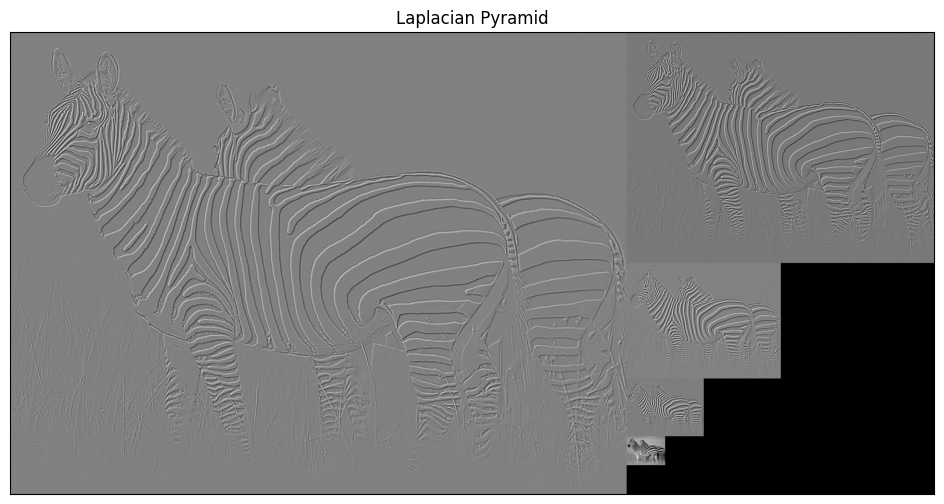

In [ ]:
'''
This function is primarily made for visualization of Laplacian Pyramid (Further explanation in Discussion)
It takes the image, mask size, level of gaussian and the resizing interpolation mode;
It calculates the gaussian pyramid of the image;
Upsampling and subtraction is done to achieve the image.
'''
def visualizepyramidlap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
  pyrG=pyramidGauss(im,sizeMask=sizeMask, nlevel=nlevel) #Getting the gaussian pyramid
  vimL=[rangeDisplay01(pyrG[nlevel])] #Laplacian Pyramid starts with the last image in the Gaussian Pyrmid
  # Using rangeDisplay01 here for the visualization later

  for i in range(nlevel, 0, -1): #We want to use images from "image of level 4" to "image of level 1", that's why i is going from 4 to 0, to loop through the images

    # Upsampling the image
    # It is done with cv2.resize, for the destination size, we want the image to have the size of the previous level so for pyrG[i] we will use the size of pyrG[i - 1] as the destination
    G = cv2.resize(pyrG[i], (pyrG[i-1].shape[1], pyrG[i-1].shape[0]), interpolation=flagInterp)
    L = pyrG[i-1] - G # Laplacian level, which is calculated by subtracting
    vimL.append(rangeDisplay01(L)) # again using rangeDisplay01 here for the visualization later

  vimL.reverse() #We should reverse it, since it is now starting from the smallest image
  return vimL

im=cv2.imread(get_image('zebra.jpg'),0)
pyrLvisual = visualizepyramidlap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrLvisual,'Laplacian Pyramid')

**2.B)Discussion**

**Laplacian Pyramids**
Laplacian pyramids start with the samllest image in the respective gaussian pyramid. For each level in the gaussian pyramid, first we upsample the image; keep in mind that we have to resize the image to the size of the image in the next level. After upsampling, we compute the difference of the upsampled image with the image in gaussian pyramid (in the next level).  
Then, we move on to the next level, and repeat the process to create the Laplacian Pyramid.

In the output image it can be seen that the operation in each level gives us the edge of images.

Regarding the Code:

The function visualizepyramidlap, was specifically made to visualize the laplacian pyramid. As it can be seen the rangeDisplay01 was used to normalize the range of the images (once in rangeDisplay01(pyrG[nlevel] and the other in vimL.append(rangeDisplay01(L))). This desicion was made due to the fact that, originally when the pyramid was visualized, the image was really dark grey and the edges weren't detectable with eye. Now with adding the rangeDisplay01, we can see that the images are much more evident in visualization.

However, when this laplacian pyramid was used, later in the reconstruction part 2.C, I didn't get satisfactory results, getting an error of reconstruction of 0.3 for the last image, while it should be 0, as we know we can fully reconstruct the image from a laplacian pyramid.

Therefore, I decided to have another function for calculating the laplacian pyramid which can be used further in the following parts of the assignment (in all of the following exercises, the output of the following function of pyramidLap was used.).


In [ ]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
  pyrG=pyramidGauss(im,sizeMask=sizeMask, nlevel=nlevel) #Getting the gaussian pyramid
  vimL=[pyrG[nlevel]] #Laplacian Pyramid starts with the last image in the Gaussian Pyrmid
  # Using rangeDisplay01 here for the visualization later

  for i in range(nlevel, 0, -1): #We want to use images from "image of level 4" to "image of level 1", that's why i is going from 4 to 0, to loop through the images

    # Upsampling the image
    # It is done with cv2.resize, for the destination size, we want the image to have the size of the previous level so for pyrG[i] we will use the size of pyrG[i - 1] as the destination
    G = cv2.resize(pyrG[i], (pyrG[i-1].shape[1], pyrG[i-1].shape[0]), interpolation=flagInterp)
    L = pyrG[i-1] - G # Laplacian level, which is calculated by subtracting
    vimL.append(L) # again using rangeDisplay01 here for the visualization later

  vimL.reverse() #We should reverse it, since it is now starting from the smallest image
  return vimL

im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)


## C) (0.5 points)

Now implement a function to reconstruct the image encoded/stored in the Laplacian pyramid. Verify that it is possible to obtain an exact copy of the original image. To do this, calculate the reconstruction error as the Euclidean norm of the differences between the intensity levels of the original image and the reconstructed image.

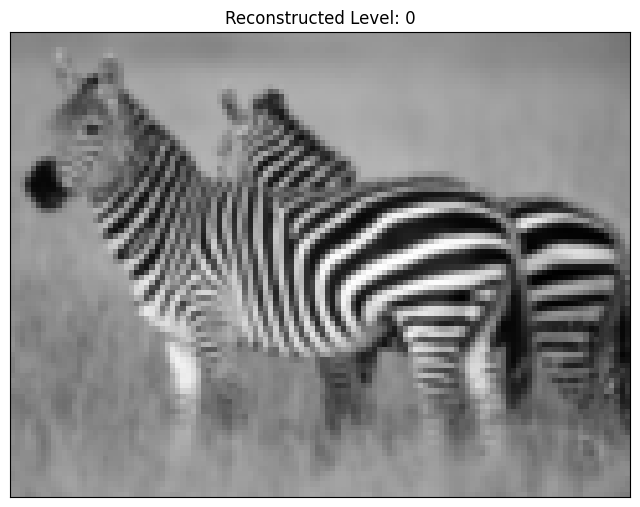

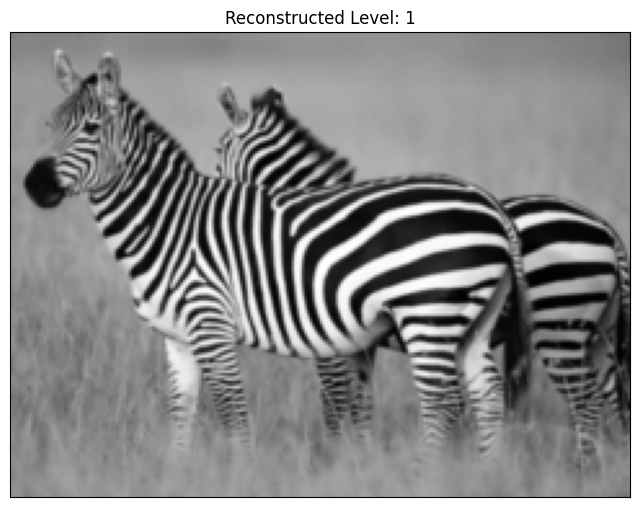

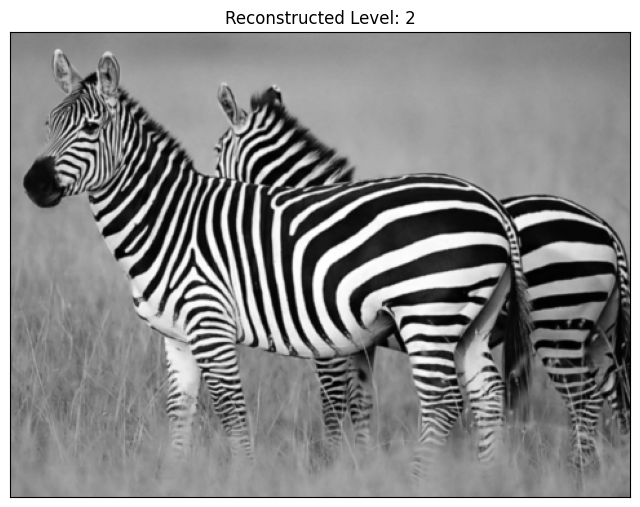

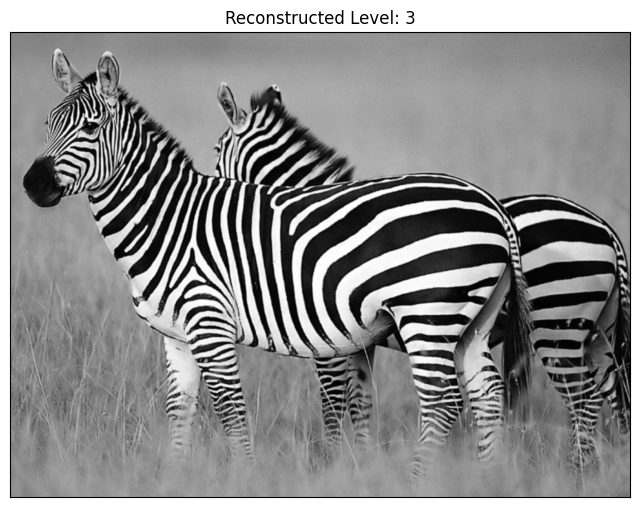

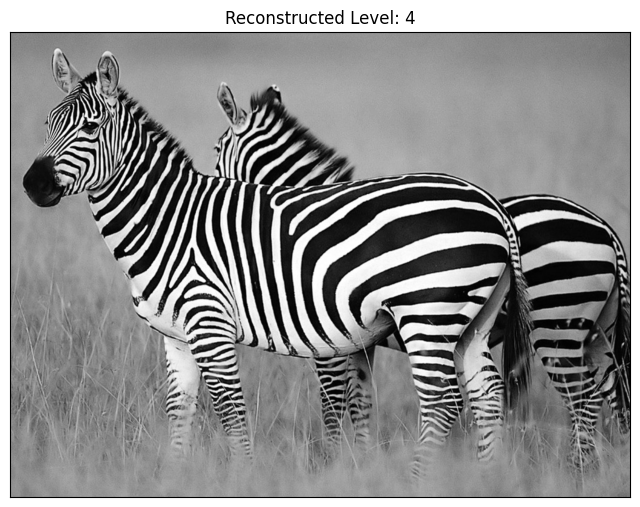

Error per pixel 0.0


In [ ]:
'''
This function takes Laplacian Pyramid of an image we want to reconstruct, and the resizing interpolation mode;
It calculates the reconstruction of the image in each level of the pyramid;
and saves it in a list which is the output
'''

def reconstructLap(pyrL,flagInterp=cv2.INTER_LINEAR):
  recon = []

  base = pyrL[-1] # Smallest image in the laplacian pyramid, which is the base image

  recon.append(base) # Adding the smaller image to the recon list

  temp = base # Creating a temperory image from the base which will change in every iteration in size

  for level in range(len(pyrL)-2, -1, -1): # indexing starts from 3 –> 3,2,1,0, we are not including 4, since we aren't including the base in the iteration
        # Upsample the current base image to the size of the next level
        upsampled = cv2.resize(temp, (pyrL[level].shape[1], pyrL[level].shape[0]), interpolation=flagInterp)

        # Add the upsampled image to the Laplacian image at the current level
        new_base = upsampled + pyrL[level]

        recon.append(new_base)  # Append the newly reconstructed image to the list
        temp = new_base  # Update the base for the next iteration

  return recon

Reconstructed_images = reconstructLap(pyrL)
for i, img in enumerate(Reconstructed_images):
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    displayIm(img,f'Reconstructed Level: {i}',1)  # Display the image in grayscale


recons = Reconstructed_images[4] # Getting the last reconstruction from the list
print('Error per pixel',np.sqrt(np.linalg.norm(im-np.round(recons), ord=2)/np.prod(im.shape)))

**2.C)Discussion**

The reconstruction of the image from Laplacian Pyramid, starts from the smallest image in the pyramid. First we upsample this image to the size of the image in the next level. Then, the upsampled image is added to the next image in the laplacian pyramid. This new image, is the reconstructed image correponding to the current level of pyramid.
We continue this procedure, applying all the operations on the new image. In the end we will have a reconstructed image, which is identical to the original image.
As it can be seen the error per pixel was calculated for the last reconstructed image, and it is 0, indicating that it is in fact possible to reconstruct the original image from the Laplacian Pyramid.

# **Exercise 3: Hybrid Images** (2 points)

This exercise is inspired on the following paper: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$. (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

The goal is to learn how the distance affects the human visual system when it extracts information about an object. To do this, we build a hybrid image from two images of different objects. By properly mixing part of the high frequencies of one image with part of the low frequencies of another image, we obtain a hybrid image whose perception differs with distance. The sigma used to filter both images (both high and low frequencies) is the key aspect to select the high and low frequency range of each image. The higher the sigma value, the greater the removal of high frequencies from the image. It is recommended to choose this value separately for each of the images and, in fact, it is possible (and even desirable) to have different values for different pairs of images. Remember to use the Gaussian pyramid to show the effect obtained.

In particular, the students are required to generate, at least, the hybrid images corresponding to Einstein-Marilyn, Cat-Dog, and Fish-Submarine, as shown below.

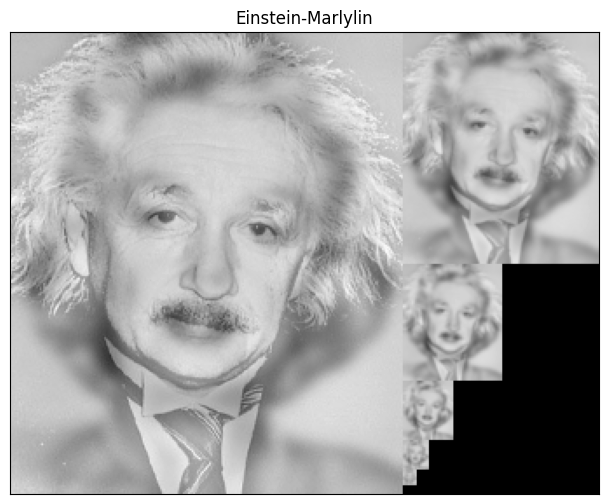

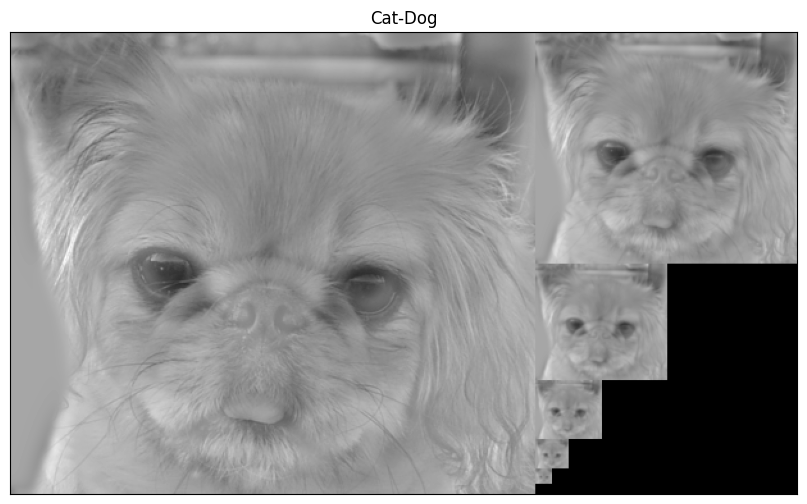

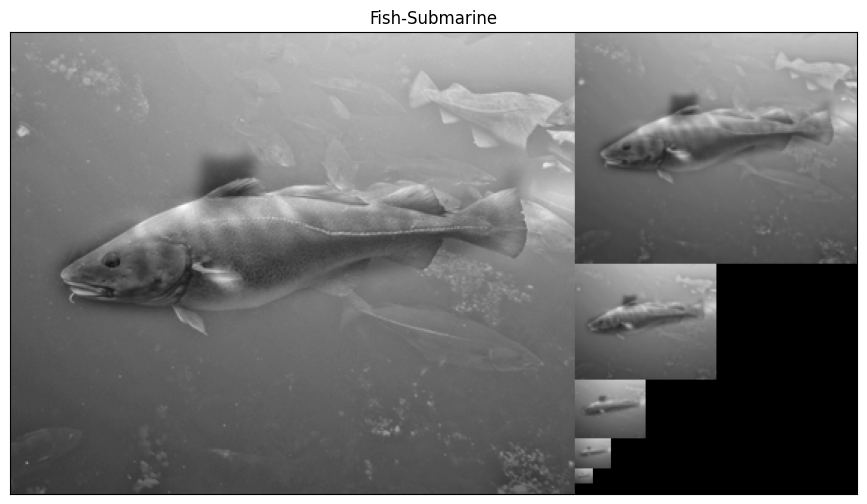

In [ ]:
'''
  This function receives two images with their corresponding sigmas which will
  be used later for appliyng gassian smoothing on them. img1 and sigma1 are related
  to the low frequency image and the others to the high frequency one.
'''

def HybridImage(img1, sigma1, img2, sigma2):
  # We want to perform smoothing on images, in order to have low frequensies
  # Therefore, orders of 0,0 which is gaussian smoothing is suitable
  orders=[0,0]

  # Low frequency image
  low = rangeDisplay01(my2DConv(img1, sigma1, orders),True)

  # high frequency image
  smooth = my2DConv(img2, sigma2, orders)
  # Subtracting an image by its smooth version (low frequensies) will give us high frequencies
  high = rangeDisplay01(img2 - smooth)

  # Hybrid
  Hybrid = high + low

  return Hybrid


Einstein = cv2.imread(get_image('einstein.bmp'),0)
Marilyn  = cv2.imread(get_image('marilyn.bmp'),0)

cat = cv2.imread(get_image('cat.bmp'),0)
dog  = cv2.imread(get_image('dog.bmp'),0)

fish = cv2.imread(get_image('fish.bmp'),0)
submarine  = cv2.imread(get_image('submarine.bmp'),0)

Hybrid1 = HybridImage(Marilyn, 4, Einstein, 7) #Marilyn as low

Hybrid2 = HybridImage(cat, 5, dog, 8) #cat as low

Hybrid3 = HybridImage(submarine, 4, fish, 7) #submarine as low

pyrG1 = pyramidGauss(Hybrid1,sizeMask=7, nlevel=5)

pyrG2 = pyramidGauss(Hybrid2,sizeMask=7, nlevel=5)

pyrG3 = pyramidGauss(Hybrid3,sizeMask=7, nlevel=5)

displayPyramid(pyrG1,'Einstein-Marlylin')
displayPyramid(pyrG2,'Cat-Dog')
displayPyramid(pyrG3,'Fish-Submarine')


**3. Discussion**

Hybrid images are made by properly mixing parts of the high frequency of one image with parts of low frequency of another image. When looking at hybrid images from different distances, we start to see other interpretations. This is due to the fact that low frequencies prevail at long distances, while high frequencies prevail at short distances. With a Gaussian pyramid we can see the results of the hybrid image, and we can simulate looking at images from different distances. As we go deeper into the pyramid, the image with low frequencies will be more evident, confirming the fact that from a distance that image will be seen with our eyes.

In creating the hybrid image, it is important how to choose the low frequency and high frequency image in order to get the appropriate effect. The reason behind my desicion was that I chose images with more sharp edges and finer details (high frequensies) as the high frequency image, since they would be more evident when you look at an image up close and from short distance (higher resolusions). I also chose the image with general regions (shapes) that are more recognizable, as the low frequency image. For instance in the context of Einstein and Marylin, Einstein's face has more details such as the mustache, eyeborow hairs, the wrinkels, also there are a lot of edges related to his hair.

Another importatn desicion is the sigma for smoothing the low frequency image and the sigma for obtaining the high frequency image.
Upon different trials with high and low values for both sigma, I got to choose the final numbers:

1.The appropriate sigma for the smoothing of low frequency image should be high enough to remove the fine details of the image, but the overal shape and major features are still recognizable. For instance sigma of 1 is too low, the blurring is not satisfactory, and Marylin's face will be completely evident in the hybrid image, while it's the opposite we are aiming for. Bellow you can see the hybrid image with sigma1 = 1, sigma2 = 10.  

<img src="https://drive.google.com/uc?export=view&id=13rqA7p_HGC2eBIDOfBOKK_TVIIMd_bHz" width="300" height="255">

By increasing the sigma for Marilyn, I chose 4 as an appropriate number for smoothing.

2.As for the sigma for high Frequensy image, the sigma should be large enough to smooth over small variations in pixel intensity, and give us the details in the image. I first started with the sigma of 1 for Einstein. Bellow you can see the hybrid image with sigma1 = 4 (previously chosen for Marlylin), sigma2 = 1.

<img src="https://drive.google.com/uc?export=view&id=1AJ2fx661IvtsECzuquCc8TOpYfRt8IpN" width="300" height="255">

As you can see the Einstein image is mostly edges while all the low frequencies are gone from the image. When the sigma for high frequency image is set too low, the smoothing effect is insufficient, and the subsequent subtraction may remove too much of the finer details we want to preserve. So we have to increase this sigma too.

In the end looking at the pyramid with the two chosen sigmas, I believe the effect is evident, as we go deeper in the pyramid, Marylin's face becomes more and more evident.

Cat/Dog Hybrid:
For the cat/dog hybrid I chose the dog as the high frequency image since it has more hairs/details and edges, and first used the same pair of sigmas as for Einstein/Marylin. The result looked fine and we could see the effect of distance well but, I wanted the details of the dog to be more evident; therefore, I increased the sigma form 7 to 8 for the dog, and also the sigma for the cat from 4 to 5; this transition made the features of the dog more evident from up close.

Fish/Submarine Hybrid:
I chose the fish image as the high frequency as it has more details, while the submarine one has a constant background of the ocean with no details or edges.
Again I repeated the procedure with the same sigmas as Einstein/Marylin. The sigmas worked well with this hybrid, as in the first image we can clearly see the fish and deeper in the pyramid the submarine can be seen.


# **Exercise 4: Pyramid Blending** (1 point)

In this exercise you must create the merged image (horizontal) of the apple (`apple.jpg`) and the orange (`orange.jpg`) using the $\textit{Pyramid Blending}$ technique. It is recommended to use the OpenCV functions `pyrDown` and `pyrUp` (and explain its working/functioning). It is also essential to explain in detail the process followed when creating the new image (mixture of both), and the blending effect in the resulting image should be appropriate (like in the example displayed below).  



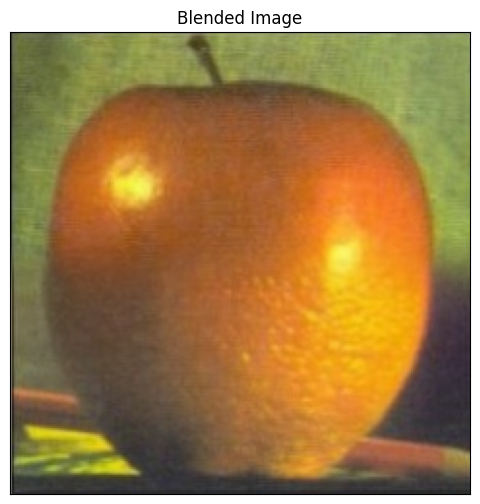

In [ ]:
# Exercise 4.1
'''
In this Code block, I use my own functions of pyramidLap, pyramidGauss and reconstructLap.
In the next Code block, I will use PyrUp and PurDown as suggested.
'''

A = readIm(get_image('apple.jpg'),1)
B = readIm(get_image('orange.jpg'),1)

#Resizing orange to the size of apple image
height, width = A.shape[:2]
B = cv2.resize(B, (width, height))

# Building Laplacian Pyramids for A,B
LapA  = pyramidLap(A, sizeMask=7,nlevel=6,flagInterp=cv2.INTER_LINEAR) # the bottom of the Lap-pyr holds the last (smallest) Gauss level
LapB  = pyramidLap(B, sizeMask=7,nlevel=6,flagInterp=cv2.INTER_LINEAR)


# Building Gaussian Pyramids for the mask
Mask = np.zeros_like(A)
Mask[:int(height/2), :] = 1 # make the mask half-and-half, upper half is full of ones
# Apply gaussian smoothing to the mask, so the transition from the black to white region of the mask is smoother
sizeMask = 50 # using a high sizemask/sigma to blur the edges of the mask
sigma = (sizeMask-1)/6
Mask = my2DConv(Mask, sigma, [0,0])
GPyrM = pyramidGauss(Mask,sizeMask=7, nlevel=6)

# Now blend images according to mask in each level
LS = []
for la,lb,gm in zip(LapA,LapB,GPyrM): # Going through each level of pyramids
  ls = la * gm + (1.0 - gm)*lb # Mixing based on the formula
  LS.append(ls)

# now reconstruct
Reconstructed_images = reconstructLap(LS)
displayIm(Reconstructed_images[6],'Blended Image',2)



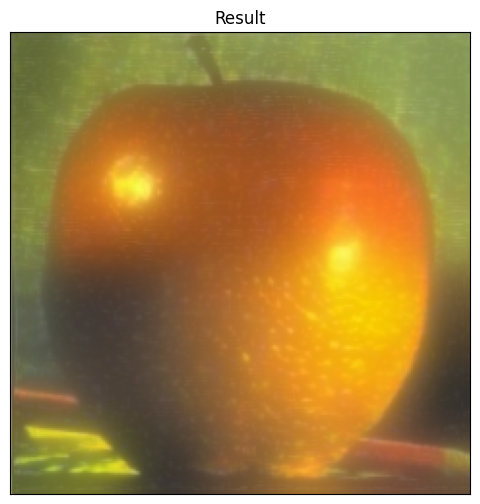

In [ ]:
# Exercise 4.2

'''
In this Code block, I used PyrUp and PurDown as suggested.
'''

A = readIm(get_image('apple.jpg'),1)
B = readIm(get_image('orange.jpg'),1)

#Resizing orange to the size of apple image
height, width = A.shape[:2]
B = cv2.resize(B, (width, height))

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G] # The original image added to the pyramid
for i in range(4): #
   G = cv2.pyrDown(G) # pyrDown does smoothing and subsampling together
   gpA.append(G)

# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(4):
   G = cv2.pyrDown(G)
   gpB.append(G)

# Building Gaussian Pyramids for the mask
Mask = np.zeros_like(A)
Mask[:int(height/2), :] = 1 # make the mask half-and-half
# Apply gaussian smoothing to the mask, so the transition from the black to white region of the mask is smoother
sizeMask = 50
sigma = (sizeMask-1)/6
Mask = my2DConv(Mask, sigma, [0,0])

# generate Gaussian pyramid for the Mask
G = Mask.copy()
gpM = [G]
for i in range(4):
   G = cv2.pyrDown(G)
   gpM.append(G)

# generate Laplacian pyramid for the images
lpA = [gpA[4]]
for i in range(4,0,-1):
   size = gpA[i-1].shape[1], gpA[i-1].shape[0]
   GE1 = cv2.pyrUp(gpA[i],dstsize=size)
   L1 = cv2.subtract(gpA[i-1], GE1)
   lpA.append(L1)

# generate Laplacian Pyramid for B
lpB = [gpB[4]]
for i in range(4,0,-1):
   size = gpB[i-1].shape[1], gpB[i-1].shape[0]
   GE2 = cv2.pyrUp(gpB[i],dstsize=size)
   L2 = cv2.subtract(gpB[i-1], GE2)
   lpB.append(L2)

# We should reverse gpM, cause now it starts from the biggest image, while laplacian pyramids are reverse of this
gpM.reverse()

# Now blend images according to mask in each level
blend = []
for la,lb,gm in zip(lpA,lpB,gpM):
  bl = la * gm + (1.0 - gm)*lb
  blend.append(bl)

# Now reconstruct
recon = blend[0]
for i in range(1,5):
  size = blend[i].shape[1], blend[i].shape[0]
  recon = cv2.pyrUp(recon,dstsize=size)
  recon = cv2.add(recon , blend[i])

displayIm(recon)

**4. Discussion**

In this esxersice, we created a merged image by blending the pyramids of the two image and a mask. The apple and orange images were used, which were different in size, so I first made them the same size. A mask of the region we are interested in was created. Here, the task was to create a horizontal blended image, so the mask was the size of the images with its upper half equal to one (white), while the below part was equal to zero (black).
The main objective of this method is to have a blended image, while the transition from one image to another is smooth rather than a sudden change.
I did this exercise twice; one with my own functions that were created during this assignment and the other with PyrUp and PyrDown functions. While the functions are different in these two approaches, their main intuition is the same.
First we have to Generate the Laplacian pyramids of the two image. Then, after creating the mask, we have to create the Gaussian pyramid of the mask. Then, this Gaussian pyramid was used as a weight to blend the two Laplacian pyramids as below:

L = GR * LA + (1-GR) * LB

Then, with this new blended pyramid, we can reconstruct the image. The intuition behind this reconstruction is same as the one discussed in 2.C.
Looking at the two images, the only difference is the functions which were used; I think both images look more or less the same and both methods gave satisfactory results.

**About the mask**

As it was mentioned, the mask that was created was a horzontal mask made of zeros and ones. At first, working with the Gaussian Pyramid of this mask, looking at the output, it was evident that the line where the two images were connected wasn't so smooth, and it was a sudden change going from apple to orange. This is due to the fact that in the mask that was used, the change from white to black is sudden. Therefore, I decided to smooth this transision, by applying a Gaussian smoothing on the mask itself before creating the Gaussian Pyramid. For this purpose, I used my my2Dconv with orders of [0,0] and a sizeMask of 50. I chose this number by trials of different numbers. We know as the sizeMask increase, the amount of smoothing increases also, so I thought this would be a good number to have a smooth transition from the apple to the orange.


**How pyrDown and pyrUp Work**

1. PyrDown: This function reduces the size of an image to half of its size. The process involves blurring the image and then downsampling, meaning selecting every second pixel and row, thus reducing the size of the image to half of the original image. Therefore, we can construct the Gaussian pyramid by consecutively applying pyrDown to the original image or the previously downsampled image, since it already has blurring and downsizing. This method aligns with what we already discussed in creating Gaussian Pyramids, as we smooth and downsample images as we go deeper into the pyramid; therefore, we can easily use this function to create it.

2. PyrUp: This function does the opposite of pyrDown; it increases the size of an image to twice its original, trying to approximate the possible original image before it was downsampled. This involves upsampling (inserting zero rows and columns), followed by blurring. Therefore, we can use it in the process of reconstructing an image from its Laplacian pyramid. This function and how it works aligns with what we've already seen happens in creating the Laplacian pyramid, in which first, we select the smallest image in the Gaussian Pyramid, we upsample it to the size of the next image, then we subtract it from the next image in the pyramid.

3. Reconstructing the image with pyrUp
We already know that the reconstruction of the image, starts from the smallest image in the pyramid. First we upsample this image to the size of the image in the next level; this procedure can easily be done with pyrUp. Then, the upsampled image is added to the next image in the laplacian pyramid.

**Some notes about the codes:**
1. First it can be seen that the size of two images are different, so in order to be able to further do calculations with the images and blend them, I decided to change the size of orange image to the size of apple image.

2. Using Pyrup, it seems that it is needed to specify the size when resizing. If not, for instance in generating Laplacian pyramid for image A, when calculating cv2.subtract(gpA[i-1], GE1), we would get an error that the GE1 and gpA are not the same size, and GE which is the output of cv2.pyrUp, is 1 pixel off.



